<a href="https://colab.research.google.com/github/Alx-a-cod/MLiterallyConfused/blob/main/ML_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**=== Fashion-MNIST (Classification, CNN) ===**

`Characteristics`

* Shape: 60,000 train images (28×28 grayscale) + 10,000 test
* No missing values (images are complete)
* Pixel values: 0–255 (uint8)

No missing values, no outliers ---> (images are bounded [0,1]).  

`Dimensionality`

* Original: 784
* Target for PCA/Autoencoder: d = 50 or d = 100

In [14]:
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
import numpy as np

# ==== Load ====
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# ==== Split train into train + val (85/15 from 60k) ====
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.15,
    stratify=y_train_full,
    random_state=42
)

# ==== Flatten and normalize to [0, 1] ====
X_train = X_train.reshape(-1, 784).astype('float32') / 255.0
X_val = X_val.reshape(-1, 784).astype('float32') / 255.0
X_test = X_test.reshape(-1, 784).astype('float32') / 255.0

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Classes: {np.unique(y_train)}")  # Should be [0, 1, ..., 9]
print(f"Pixel range: [{X_train.min()}, {X_train.max()}]")  # Should be [0.0, 1.0]

Train: (51000, 784), Val: (9000, 784), Test: (10000, 784)
Classes: [0 1 2 3 4 5 6 7 8 9]
Pixel range: [0.0, 1.0]


PCA - Fashion-MNIST
Train: (51000, 50)
Val: (9000, 50)
Test: (10000, 50)
Total variance explained by 50 PCs: 0.8626 (86.26%)


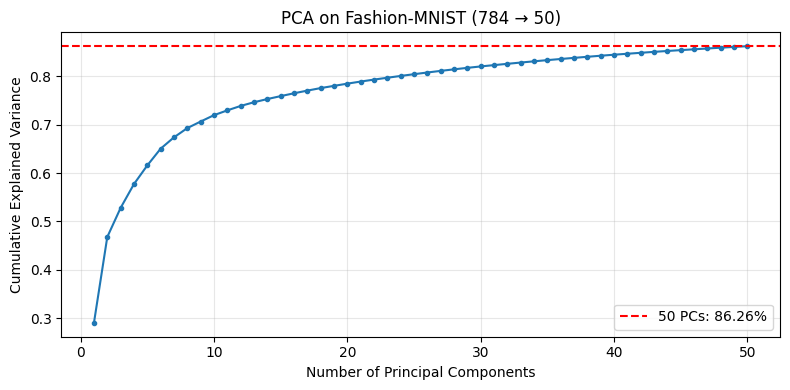

In [15]:
from sklearn.decomposition import PCA
import numpy as np

# ==== Assuming you have X_train, X_val, X_test from preprocessing ====
# X_train shape: (51000, 784)
# X_val shape: (9000, 784)
# X_test shape: (10000, 784)

# ==== PCA: reduce to 50 dimensions ====
pca_fmnist = PCA(n_components=50, random_state=42)

# Fit on training data only
X_train_pca = pca_fmnist.fit_transform(X_train)
X_val_pca = pca_fmnist.transform(X_val)
X_test_pca = pca_fmnist.transform(X_test)

# ==== Verify shapes ====
print(f"PCA - Fashion-MNIST")
print(f"Train: {X_train_pca.shape}")  # (51000, 50)
print(f"Val: {X_val_pca.shape}")      # (9000, 50)
print(f"Test: {X_test_pca.shape}")    # (10000, 50)

# ==== Explained variance ====
explained_var = pca_fmnist.explained_variance_ratio_.sum()
print(f"Total variance explained by 50 PCs: {explained_var:.4f} ({explained_var*100:.2f}%)")

# ==== Cumulative variance plot (for report) ====
import matplotlib.pyplot as plt

cumsum_var = np.cumsum(pca_fmnist.explained_variance_ratio_)
plt.figure(figsize=(8, 4))
plt.plot(range(1, 51), cumsum_var, marker='o', markersize=3)
plt.axhline(y=explained_var, color='r', linestyle='--', label=f'50 PCs: {explained_var:.2%}')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA on Fashion-MNIST (784 → 50)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**=== California Housing (Regression, FNN) ===**

`Characteristics`

* Shape: 20,640 samples × 8 features
* No missing values (clean dataset)
* Features: MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude
* Target: Continuous (median house value)

No missing values. Outliers exist but are real (e.g., expensive areas, high population density). To be kept.

Dimensionality:

* Original: 8
* Target for PCA/Autoencoder: d = 4 or d = 5

In [19]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# ==== Load ====
data = fetch_california_housing()
X, y = data.data, data.target

# ==== Split: 70% train, 15% val, 15% test ====
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

# ==== Check for missing values ====
print(f"Missing values in train: {np.isnan(X_train).sum()}")  # Should be 0

# ==== Outlier detection (optional, for reporting) ====
from scipy import stats
z_scores = np.abs(stats.zscore(X_train))
outliers = (z_scores > 3).any(axis=1)
print(f"Outlier rows (|z|>3): {outliers.sum()} / {X_train.shape[0]} ({100*outliers.mean():.2f}%)")

# Decision: Keep outliers (real data, small %), but report in analysis

# ==== Standardization ====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ==== Verify scaling ====
print(f"Train mean: {X_train_scaled.mean(axis=0).round(3)}")  # ~0
print(f"Train std: {X_train_scaled.std(axis=0).round(3)}")    # ~1

print(f"Train: {X_train_scaled.shape}, Val: {X_val_scaled.shape}, Test: {X_test_scaled.shape}")

Missing values in train: 0
Outlier rows (|z|>3): 591 / 14448 (4.09%)
Train mean: [-0. -0.  0. -0.  0. -0.  0. -0.]
Train std: [1. 1. 1. 1. 1. 1. 1. 1.]
Train: (14448, 8), Val: (3096, 8), Test: (3096, 8)


In [21]:
# ==== PCA: reduce to 5 dimensions ====
pca_housing = PCA(n_components=5, random_state=42)

X_train_housing_pca = pca_housing.fit_transform(X_train_scaled)
X_val_housing_pca = pca_housing.transform(X_val_scaled)
X_test_housing_pca = pca_housing.transform(X_test_scaled)

# ==== Verify shapes ====
print(f"\nPCA - California Housing")
print(f"Train: {X_train_housing_pca.shape}")  # (14448, 5)
print(f"Val: {X_val_housing_pca.shape}")      # (3096, 5)
print(f"Test: {X_test_housing_pca.shape}")    # (3096, 5)

# ==== Explained variance ====
explained_var = pca_housing.explained_variance_ratio_.sum()
print(f"Total variance explained by 5 PCs: {explained_var:.4f} ({explained_var*100:.2f}%)")

# ==== Component interpretation (for report) ====
components_df = pd.DataFrame(
    pca_housing.components_,
    columns=['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'],
    index=[f'PC{i+1}' for i in range(5)]
)
print("\nPCA Components (loadings):")
print(components_df.round(3))


PCA - California Housing
Train: (14448, 5)
Val: (3096, 5)
Test: (3096, 5)
Total variance explained by 5 PCs: 0.9018 (90.18%)

PCA Components (loadings):
     MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
PC1   0.085    -0.016     0.458      0.415      -0.161    -0.009     0.559   
PC2   0.217    -0.259     0.530      0.491       0.094    -0.002    -0.395   
PC3   0.229    -0.622    -0.063     -0.193       0.656     0.172     0.177   
PC4   0.878     0.147     0.059     -0.323      -0.282     0.112    -0.068   
PC5  -0.111     0.228     0.026      0.098       0.047     0.960    -0.019   

     Longitude  
PC1     -0.523  
PC2      0.446  
PC3     -0.167  
PC4     -0.055  
PC5      0.024  


**=== Credit Card (Clustering, K-Means) ===**  

`Characteristics`

* Source: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata
* Shape: 8,950 samples × 18 columns (17 features + 1 ID)
* Features: BALANCE, PURCHASES, CASH_ADVANCE, CREDIT_LIMIT, PAYMENTS, etc.
* Missing values: ~300 missing in CREDIT_LIMIT, MINIMUM_PAYMENTS

Missing values handled by median imputation. Outliers kept (informative for segmentation).

`Dimensionality`

* Original: 17
* Target for PCA/Autoencoder: d = 8 or d = 10

In [9]:
import kagglehub
import pandas as pd
import os

# ==== Download dataset ====
path = kagglehub.dataset_download("arjunbhasin2013/ccdata")
print("Path to dataset files:", path)

# ==== List files in downloaded directory ====
files = os.listdir(path)
print(f"Files in dataset: {files}")

# ==== Load CSV (filename is 'CC GENERAL.csv' with a SPACE) ====
csv_path = os.path.join(path, 'CC GENERAL.csv')
df = pd.read_csv(csv_path)

print(f"\nDataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Using Colab cache for faster access to the 'ccdata' dataset.
Path to dataset files: /kaggle/input/ccdata
Files in dataset: ['CC GENERAL.csv']

Dataset loaded successfully!
Shape: (8950, 18)
Columns: ['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']


In [12]:
import kagglehub
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import stats

# ==== Download dataset ====
path = kagglehub.dataset_download("arjunbhasin2013/ccdata")
csv_path = os.path.join(path, 'CC GENERAL.csv')
df = pd.read_csv(csv_path)

print(f"Shape: {df.shape}")
print(f"Missing values:\n{df.isna().sum()}\n")

# ==== Drop ID column ====
X = df.drop(columns=['CUST_ID']).values

# ==== Handle missing values ====
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

print(f"Missing values after imputation: {np.isnan(X_imputed).sum()}")

# ==== Outlier detection (for reporting) ====
z_scores = np.abs(stats.zscore(X_imputed))
outliers = (z_scores > 3).any(axis=1)
print(f"Outlier rows (|z|>3): {outliers.sum()} / {X_imputed.shape[0]} ({100*outliers.mean():.2f}%)")

# ==== Standardization ====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# ==== Verify scaling ====
print(f"Mean after scaling: {X_scaled.mean(axis=0).round(3)}")  # Should be ~0
print(f"Std after scaling: {X_scaled.std(axis=0).round(3)}")    # Should be ~1

# ==== Optional: Split for evaluation ====
X_train, X_test = train_test_split(X_scaled, test_size=0.20, random_state=42)

print(f"\nFull scaled data: {X_scaled.shape}")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Using Colab cache for faster access to the 'ccdata' dataset.
Shape: (8950, 18)
Missing values:
CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Missing values after imputation: 0
Outlier rows (|z|>3): 1516 / 8950 (16.94%)
Mean after scaling: [-0.  0.  0. -0.  0. -0.  0.  0.  0. -0. -0. -0.  0. -0.  0. -0.  0.]
Std

In [22]:
# ==== PCA: reduce to 8 dimensions ====
pca_credit = PCA(n_components=8, random_state=42)

X_train_credit_pca = pca_credit.fit_transform(X_train)
X_test_credit_pca = pca_credit.transform(X_test)

# ==== Verify shapes ====
print(f"\nPCA - Credit Card")
print(f"Train: {X_train_credit_pca.shape}")  # (7160, 8)
print(f"Test: {X_test_credit_pca.shape}")    # (1790, 8)

# ==== Explained variance ====
explained_var = pca_credit.explained_variance_ratio_.sum()
print(f"Total variance explained by 8 PCs: {explained_var:.4f} ({explained_var*100:.2f}%)")


PCA - Credit Card
Train: (14448, 8)
Test: (3096, 8)
Total variance explained by 8 PCs: 1.0000 (100.00%)
